In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import statsmodels.api as sm
from linearmodels.system import SUR

import matplotlib.pyplot as plt

import os
import datetime

### Read Data

In [2]:
# Read in the bid-ask data from WRDS
bid_ask_data = pd.read_sas('../Data/dataset_random.sas7bdat')
bid_ask_data.head()

,PERMNO,DATE,BID,ASK,BIDLO,ASKHI,VOL,PRC,decile_category
0,11394.0,2000-01-03,2.37500,2.4375,2.28125,2.37500,30025.0,2.37500,1.0
1,18148.0,2000-01-03,5.43750,5.5625,5.25000,5.68750,9540.0,5.56250,1.0
2,32062.0,2000-01-03,1.96875,2.2500,1.96875,1.96875,800.0,1.96875,1.0
3,37381.0,2000-01-03,2.93750,3.0625,2.81250,3.18750,42834.0,3.06250,1.0
4,44230.0,2000-01-03,6.62500,6.7500,6.75000,6.75000,600.0,6.75000,1.0


In [3]:
bid_ask_data.describe()

,PERMNO,BID,ASK,BIDLO,ASKHI,VOL,PRC,decile_category
count,996445.000000,996445.000000,996445.000000,996445.000000,996445.000000,9.964450e+05,996445.000000,996445.000000
mean,69084.604644,23.423330,23.540689,23.091852,23.853451,9.958194e+05,22.893952,5.475139
std,24455.118226,25.536241,25.580188,25.202897,25.902598,5.419746e+06,26.085099,2.866023
min,10032.000000,0.010000,0.032000,0.010000,0.034300,0.000000e+00,-220.449997,1.000000
25%,60506.000000,5.990000,6.060000,5.875000,6.169900,1.468200e+04,5.600000,3.000000
50%,80286.000000,16.500000,16.639999,16.250000,16.879999,8.707800e+04,16.250000,5.000000
75%,85502.000000,31.559999,31.730000,31.100000,32.099998,4.075830e+05,31.500000,8.000000
max,91556.000000,445.375000,445.437500,412.500000,471.000000,6.098595e+08,445.062500,10.000000


In [4]:
# Read in the CCI data
CCI_data = pd.read_csv('../Data/CCI.csv')
CCI_data.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-01,99.75915,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-02,99.74998,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-03,99.88835,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-04,99.95676,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1991-05,100.01380,NaN


In [5]:
# Read in the ICS data
ICS_data = pd.read_csv('../Data/ICS.csv')
ICS_data.head()

,Month,YYYY,ICS_ALL
0,November,1952,86.2
1,February,1953,90.7
2,August,1953,80.8
3,November,1953,80.7
4,February,1954,82.0


In [6]:
# Read in the SAD data
SAD_data = pd.read_csv('../Data/daily_incidence.txt', sep='\t')
SAD_data

,Julian date,Incidence
0,1,0.962275
1,2,0.961698
2,3,0.961067
3,4,0.960381
4,5,0.959638
...,...,...
361,362,0.964078
362,363,0.963701
363,364,0.963275
364,365,0.962800


### Helper Functions

In [7]:
# Get calendar month and day from Julian date
def get_month_day(julian):
    if julian < 60:
        month = datetime.datetime.strptime(str(julian), '%j').month 
        day = datetime.datetime.strptime(str(julian), '%j').day
    elif julian > 60:
        month = datetime.datetime.strptime(str(julian-1), '%j').month
        day = datetime.datetime.strptime(str(julian-1), '%j').day
    else:  # leap day
        month = 2
        day = 29
    return month, day

In [8]:
def bid_ask_estimate(df, id_col='PERMNO', date_col='DATE', high_col='ASKHI', low_col='BIDLO'):
    """
    Inputs:
     - df [DataFrame]: contains all data
     - id_col [str]: name of stock identifying column
     - date_col [str]: name of date column
     - high_col [str]: name of column for high price
     - low_col [str]: name of column for low price
    
    Return: modifies df input to contain the Corwin-Schultz estimate of the bid-ask spread
    """
    
    i = 1
    if id_col:
        for k, group in df.groupby(id_col):
            group.sort_values(date_col)
            group["next_H"] = group[high_col].shift(-1) # Get high for next day
            group["next_L"] = group[low_col].shift(-1) # Get low for next day

            if i == 1:
                temp = group
            else:
                temp = pd.concat([temp, group])

            i += 1
    else:
        temp = df.copy()
        temp["next_H"] = temp[high_col].shift(-1) # Get high for next day
        temp["next_L"] = temp[low_col].shift(-1) # Get low for next day

        
    # beta = E{sum(j=0,1)[ln(H_(t+j)/L_(t+j))]^2} where H_t is the observed high price on day t (similarly for L)
    beta = np.mean((np.log(temp[high_col]/temp[low_col])**2 + np.log(temp.next_H/temp.next_L)**2))
#     beta = (np.log(temp[high_col]/temp[low_col])**2 + np.log(temp.next_H/temp.next_L)**2)
    
    # gamma = [ln(H_(t, t+1)/L_(t, t+1))]^2 where H_(t, t+1) is the high price over days t and t+1 (similarly for L)
    gamma = (np.log(np.maximum(temp[high_col], temp.next_H)/np.minimum(temp[low_col], temp.next_L)))**2
    
    # alpha = ((2beta)^0.5-beta^0.5)/(3-2*2^0.5) - (gamma/(3-2*2^0.5))^0.5
    alpha = (np.sqrt(2*beta)-np.sqrt(beta))/(3-2*np.sqrt(2)) - np.sqrt(gamma/(3-2*np.sqrt(2)))
        
    # high-low spread estimate S = 2(e^alpha - 1)/(1+e^alpha)
    S = 2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    
    temp['CW_spread_estimate'] = S
    
    return temp

In [9]:
def split_date_field(df, date_field):
    '''
    Extracts year and month columns from date column
    
    Return: df with month and year columns
    '''
    new_df = df.copy()
    
    split_date = new_df[date_field].str.split('-', n=1, expand=True)
    
    new_df['Year'] = split_date[0].astype(int)
    new_df['Month'] = split_date[1].astype(int)
    
    return new_df
    
def get_integer_month(df, month_field, short_names=False):
    '''
    Get months as integers from string month field
    
    Return: df with updated month field to have integer values
    '''
    
    new_df = df.copy()
    
    # Check for integer months
    if pd.api.types.is_integer_dtype(df[month_field]):
        print("Month field already in integer form.")
        return df
    
    # If not integer months, convert months to integers
    if short_names:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
    
    else:
        new_df[month_field] = new_df[month_field].apply(lambda x: datetime.datetime.strptime(x, "%B").month)

    return new_df

In [10]:
def get_daily_data(df, trading_days, year_field, month_field, day_field=None, cols_to_keep=None):
    '''
    Interpolates the data on a daily basis from a monthly basis (same value between dates)
    
    Return: df with daily data
    '''
    
    trading_d = trading_days.day
    trading_months = trading_days.month
    trading_years = trading_days.year
    
    if day_field:
        date_df = pd.DataFrame({'Date': trading_days, 'Day': trading_d, 'Month': trading_months})
    else:
        date_df = pd.DataFrame({'Date': trading_days, 'Year': trading_years, 'Month': trading_months})
    
    if cols_to_keep:
        # Assume no day_field
        merged_df = date_df.merge(df[cols_to_keep+[year_field]+[month_field]], left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')
    
    else:
        if day_field:
            merged_df = date_df.merge(df, left_on=['Month', 'Day'], 
                                  right_on=[month_field, day_field], how='left')
        else:
            merged_df = date_df.merge(df, left_on=['Year', 'Month'], 
                                  right_on=[year_field, month_field], how='left')
    
    return merged_df

## Pre-process the Data - US

### (i) CCI & ICS data

In [11]:
# Extract month and year, then average the CCI data across each state
CCI_data_cleaned = CCI_data[CCI_data.LOCATION == 'USA']
CCI_data_cleaned = split_date_field(CCI_data_cleaned, 'TIME')
CCI_data_cleaned = CCI_data_cleaned.groupby(['TIME']).mean()[['Value', 'Year', 'Month']].reset_index()

# Get the integer monthly values for ICS data
ICS_data_cleaned = get_integer_month(ICS_data, 'Month')

# Get trading days
trading_days = pd.to_datetime(bid_ask_data.DATE.unique().astype(str))

# Get daily data for CCI and ICS
CCI_daily = get_daily_data(CCI_data_cleaned, trading_days, 'Year', 'Month')
ICS_daily = get_daily_data(ICS_data_cleaned, trading_days, 'YYYY', 'Month')

# Get rid of unnecessary columns, rename columns
CCI_daily = CCI_daily.drop(['Year', 'TIME', 'Month'], axis=1)
CCI_daily = CCI_daily.rename({'Value': 'CCI'}, axis='columns')
CCI_daily['CCI'] = CCI_daily['CCI']-100 # Center around 1985 (100)

ICS_daily = ICS_daily.drop(['Year', 'YYYY', 'Month'], axis=1)
ICS_daily = ICS_daily.rename({'ICS_ALL': 'ICS'}, axis='columns')

In [12]:
CCI_daily.head()

,Date,CCI
0,2000-01-03,2.9952
1,2000-01-04,2.9952
2,2000-01-05,2.9952
3,2000-01-06,2.9952
4,2000-01-07,2.9952


In [13]:
ICS_daily.head()

,Date,ICS
0,2000-01-03,112.0
1,2000-01-04,112.0
2,2000-01-05,112.0
3,2000-01-06,112.0
4,2000-01-07,112.0


### (ii) SAD data

In [14]:
# Get month and day for SAD data, and get values for trading_days
SAD_data[['Month', 'Day']] = pd.DataFrame(list(SAD_data['Julian date'].apply(lambda x: get_month_day(x))))
SAD_daily = get_daily_data(SAD_data, trading_days, None, 'Month', 'Day')[['Date', 'Incidence']]
SAD_daily.head()

,Date,Incidence
0,2000-01-03,0.961067
1,2000-01-04,0.960381
2,2000-01-05,0.959638
3,2000-01-06,0.958836
4,2000-01-07,0.957971


### (iii) bid-ask data

bid_ask_df: holds stock-level information

bid_ask_deciles: holds decile-level information

In [15]:
bid_ask_df = bid_ask_data.copy()

#### Spread Calculation

Calculated on stock level.
Result (ABS_SPREAD, REL_SPREAD) added to bid_ask_df table.

In [16]:
# Convert date field to datetime
bid_ask_df['DATE'] = pd.to_datetime(bid_ask_df.DATE.astype(str))

# Get the absolute and relative bid-ask spread data
bid_ask_df['ABS_SPREAD'] = bid_ask_df.ASK - bid_ask_df.BID
bid_ask_df['REL_SPREAD'] = (bid_ask_df.ASK - bid_ask_df.BID)*2/(bid_ask_df.ASK + bid_ask_df.BID)

#### Volume Calculation

Calculated on stock level.
Result (DLR_VOL) added to bid_ask_df table.

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Get relevant columns
bid_ask_subset = bid_ask_df[['PERMNO', 'DATE', 'decile_category', 'VOL', 'PRC']].copy()

# Get the dollar volume for the previous day for each stock
i = 1
for permno, group in bid_ask_subset.groupby('PERMNO'):
    group.sort_values('DATE')
    group['PRC_shifted'] = abs(group['PRC']).shift(1) # Shifted price, taking absolute values
    group['VOL_shifted'] = group['VOL'].shift(1) # Shifted volume
    group['DLR_VOL'] = group.PRC_shifted*group.VOL_shifted # Previous day's dollar volume

    if i == 1:
        bid_ask_vol = group
    else:
        bid_ask_vol = pd.concat([bid_ask_vol, group])
        
    i += 1
    
# Save results to bid_ask_df table
bid_ask_df['DLR_VOL'] = bid_ask_vol['DLR_VOL'] 

#### Return Calculation

Calculated on stock level.
Result (DLY_RETURN) added to bid_ask_df table.

In [18]:
import warnings
warnings.filterwarnings("ignore")

bid_ask_subset = bid_ask_df[['DATE', 'PERMNO', 'decile_category', 'PRC']].copy()

# Get the individual stock returns for each stock
i = 1
for permno, group in bid_ask_subset.groupby('PERMNO'):
    group.sort_values('DATE')
    group['PRC_shifted'] = group['PRC'].shift(1) # Shifted price
    group['daily_return'] = (abs(group.PRC)-abs(group.PRC_shifted))/abs(group.PRC_shifted) # Return
    
    if i == 1:
        bid_ask_return = group
    else:
        bid_ask_return = pd.concat([bid_ask_return, group])
    i += 1

bid_ask_df['DLY_RETURN'] = bid_ask_return['daily_return'] # Save to bid_ask_df table

#### Variance Calculation

Calculated on stock level.
Result (DLY_VARIANCE) added to bid_ask_df table.

In [19]:
# Remove NaN rows
bid_ask_return = bid_ask_return.dropna()

# Get the variances based on 21-day periods for each stock
period_length = 21
i = 1
for permno, group in bid_ask_return.groupby('PERMNO'):
    group.sort_values('DATE')
    group['variance'] = group.daily_return.rolling(period_length).var()
    
    if i == 1:
        bid_ask_var = group
    else:
        bid_ask_var = pd.concat([bid_ask_var, group])
    i += 1

bid_ask_df['DLY_VARIANCE'] = bid_ask_var['variance'] # Save to bid_ask_df table

In [20]:
bid_ask_df = bid_ask_df.dropna() # Remove NaN values

#### Detrend Calculations on Decile Level

##### Aggregate Spread Data

Calculated on decile level. Result (ABS_SPREAD, REL_SPREAD) saved to bid_ask_deciles.

In [21]:
# Get the equal-weighted averages of firm-specific daily closing quoted spreads
bid_ask_deciles = bid_ask_df[['DATE', 'decile_category', 'ABS_SPREAD', 'REL_SPREAD']].groupby(['DATE', 'decile_category']).mean().reset_index()

##### Detrend Volume and Variance

Calculated on decile level.
Result (DLR_VOL_detrended, VAR_detrended) added to bid_ask_deciles table.

In [22]:
# Get average dollar volume and variance across each decile
bid_ask_grouped = bid_ask_df[['DATE', 'decile_category', 'DLR_VOL', 'DLY_VARIANCE']].groupby(['DATE', 'decile_category']).mean().reset_index()

# Calculate average (volume, variance) over last 252 days for each decile
for i, group in bid_ask_grouped.groupby('decile_category'):
    group.sort_values('DATE')
    group['AVG_DLR_VOL'] = group.DLR_VOL.rolling(252).mean()
    group['AVG_VAR'] = group.DLY_VARIANCE.rolling(252).mean()
    
    if i == 1:
        averaged_data = group
    else:
        averaged_data = pd.concat([averaged_data, group])
        
# Calculate the detrended volume and variance
averaged_data['DLR_VOL_detrended'] = averaged_data.DLR_VOL/averaged_data.AVG_DLR_VOL
averaged_data['VAR_detrended'] = averaged_data.DLY_VARIANCE/averaged_data.AVG_VAR

# Save to bid_ask_deciles table
bid_ask_deciles['DLR_VOL_detrended'] = averaged_data['DLR_VOL_detrended'] 
bid_ask_deciles['VAR_detrended'] = averaged_data['VAR_detrended'] 

In [23]:
# Remove NaN rows
bid_ask_deciles = bid_ask_deciles.dropna().rename(columns={'DATE':'Date'})
bid_ask_deciles

,Date,decile_category,ABS_SPREAD,REL_SPREAD,DLR_VOL_detrended,VAR_detrended
2510,2001-01-31,1.0,0.192188,0.033885,0.166100,1.408344
2511,2001-01-31,2.0,0.160938,0.030958,0.450148,0.951517
2512,2001-01-31,3.0,0.270313,0.029652,0.547756,1.116444
2513,2001-01-31,4.0,0.279687,0.018133,0.533138,1.173260
2514,2001-01-31,5.0,0.210938,0.014925,0.712707,1.060812
...,...,...,...,...,...,...
50095,2019-12-31,6.0,0.030500,0.001042,0.785246,0.864788
50096,2019-12-31,7.0,0.047500,0.000948,0.689894,0.893220
50097,2019-12-31,8.0,0.022500,0.000549,0.606937,0.590399
50098,2019-12-31,9.0,0.055499,0.000472,0.707288,0.425692


### (iii) combine data

In [24]:
# Combine datasets into two dataframes: bid_ask_deciles and CCI_daily, ICS_daily
all_data = bid_ask_deciles.merge(CCI_daily, on=['Date'], how='left')
all_data = all_data.merge(ICS_daily, on=['Date'], how='left')
all_data = all_data.merge(SAD_daily, on=['Date'], how='left')
all_data = all_data.set_index('Date')
all_data

,decile_category,ABS_SPREAD,REL_SPREAD,DLR_VOL_detrended,VAR_detrended,CCI,ICS,Incidence
Date,,,,,,,,
2001-01-31,1.0,0.192188,0.033885,0.166100,1.408344,1.1058,94.7,0.909548
2001-01-31,2.0,0.160938,0.030958,0.450148,0.951517,1.1058,94.7,0.909548
2001-01-31,3.0,0.270313,0.029652,0.547756,1.116444,1.1058,94.7,0.909548
2001-01-31,4.0,0.279687,0.018133,0.533138,1.173260,1.1058,94.7,0.909548
2001-01-31,5.0,0.210938,0.014925,0.712707,1.060812,1.1058,94.7,0.909548
...,...,...,...,...,...,...,...,...
2019-12-31,6.0,0.030500,0.001042,0.785246,0.864788,1.6538,99.3,0.962275
2019-12-31,7.0,0.047500,0.000948,0.689894,0.893220,1.6538,99.3,0.962275
2019-12-31,8.0,0.022500,0.000549,0.606937,0.590399,1.6538,99.3,0.962275


## Visualize Data - US

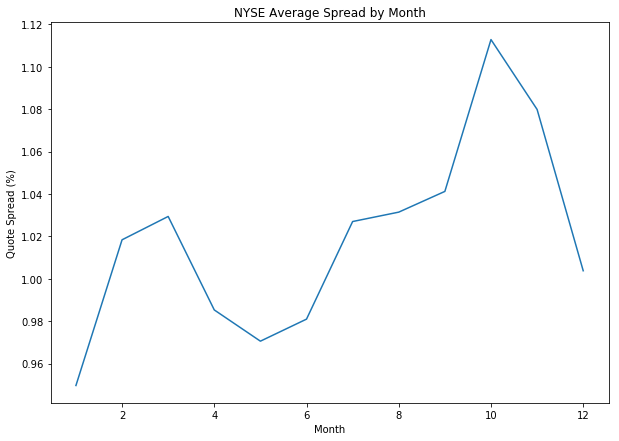

In [25]:
test_data = all_data.reset_index()
month = test_data['Date'].apply(lambda x: x.month)
test_data['Month'] = month
test_data2 = test_data.groupby('Month').mean()['REL_SPREAD']*100
test_data2.plot(title='NYSE Average Spread by Month', ylabel='Quote Spread (%)', legend=False, figsize=(10,7))

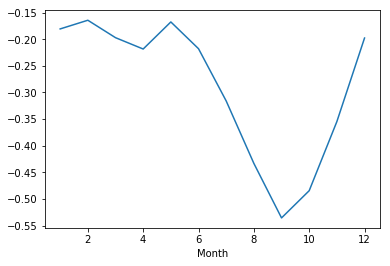

In [26]:
test_data3 = test_data.groupby('Month').mean()['CCI']
test_data3.plot()

# Check sentiment (always negative)

In [27]:
def plot(df, plot_col, groupby_col):
    plt.figure()
    plot_df = df.pivot(columns=groupby_col, values=plot_col)
    plot_df.plot(ylim=(0,0.2), title='RSpread by Decile', figsize=(15,10))
    return

<Figure size 432x288 with 0 Axes>

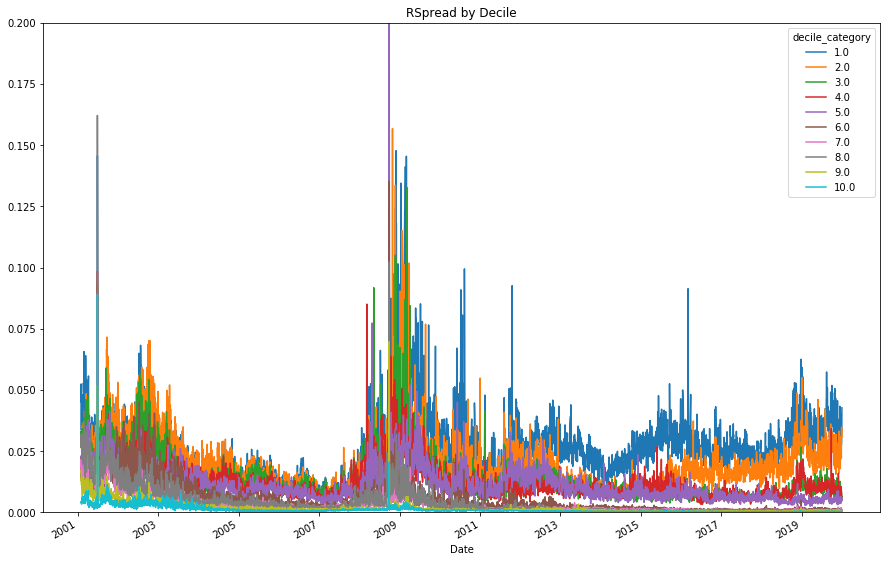

In [28]:
# average bid-ask spread by decile
plot(all_data, 'REL_SPREAD', 'decile_category')

#### Get Summary Statistics - US

In [29]:
pd.set_option('float_format', '{:.2f}'.format)

# Summary over all US data
summary_cols = ['Quote Spread (%)', 'Bid ($)', 'Ask ($)', 'Volume ($million)', 'Daily Return (%)', 'Return Variance (%)']

bid_ask_df['Quote Spread (%)'] = bid_ask_df.REL_SPREAD*100
bid_ask_df['Bid ($)'] = bid_ask_df.BID
bid_ask_df['Ask ($)'] = bid_ask_df.ASK
bid_ask_df['Volume ($million)'] = bid_ask_df.DLR_VOL/1000000
bid_ask_df['Daily Return (%)'] = bid_ask_df.DLY_RETURN*100
bid_ask_df['Return Variance (%)'] = bid_ask_df.DLY_VARIANCE*100

bid_ask_df[summary_cols].describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Quote Spread (%),1.09,2.39,0.00,198.37
Bid ($),23.41,25.49,0.01,445.38
Ask ($),23.53,25.54,0.03,445.44
Volume ($million),22.22,95.95,0.00,10217.16
Daily Return (%),0.14,40.19,-81.91,39344.44
Return Variance (%),16.14,3391.59,0.00,737246.06


In [30]:
pd.set_option('float_format', '{:.2f}'.format)

# Summary over US decile data
summary_cols = ['Quote Spread (%)', 'Detrended Volume (%)', 'Detrended Variance (%)']

bid_ask_deciles['Quote Spread (%)'] = bid_ask_deciles.REL_SPREAD*100
bid_ask_deciles['Detrended Volume (%)'] = bid_ask_deciles.DLR_VOL_detrended*100
bid_ask_deciles['Detrended Variance (%)'] = bid_ask_deciles.VAR_detrended*100

for i, group in bid_ask_deciles.groupby('decile_category'):
    temp = group[summary_cols].describe().transpose()[['mean', 'std', 'min', 'max']]
    temp['Decile'] = i
    
    if i == 1:
        summary_df = temp
    else:
        summary_df = pd.concat([summary_df, temp])

summary_df.index.name = 'Variable'
summary_df = summary_df.reset_index().set_index(['Decile','Variable'])

In [31]:
summary_df

mean    std   min      max
Decile Variable                                           
1.00   Quote Spread (%)         2.76   1.53  0.47    36.33
       Detrended Volume (%)   102.97 148.70  7.11  3455.36
       Detrended Variance (%) 141.69 552.40  0.66 18997.72
2.00   Quote Spread (%)         2.05   1.15  0.38    17.91
       Detrended Volume (%)   102.20  83.54 14.52  2241.20
       Detrended Variance (%) 124.94 392.64  2.44 11672.06
3.00   Quote Spread (%)         1.42   1.02  0.35    14.43
       Detrended Volume (%)   100.05  75.27  9.07  1401.23
       Detrended Variance (%) 148.09 727.19  0.00 25165.19
4.00   Quote Spread (%)         1.25   0.71  0.33    17.69
       Detrended Volume (%)   105.28 107.12  6.74  3167.24
       Detrended Variance (%) 123.67 442.39  1.51 14197.69
5.00   Quote Spread (%)         1.13   0.71  0.25    20.65
       Detrended Volume (%)    99.18  66.98 12.98  2491.72
       Detrended Variance (%)  99.53  62.62 21.74   780.21
6.00   Quote Spread (%)         0.55   0.64  0.08    13.54
       Detrended Volume (%)    97.70  70.62  4.06  1338.53
       Detrended Variance (%)  99.03  57.20 24.73   474.62
7.00   Quote Spread (%)         0.34   0.42  0.05     8.94
       Detrended Volume (%)   102.09  41.45 21.53   558.81
       Detrended Variance (%) 117.63 379.28  0.72 16447.37
8.00   Quote Spread (%)         0.41   0.59  0.04    16.22
       Detrended Volume (%)    97.64  49.54  2.25   779.21
       Detrended Variance (%) 107.89 261.84  2.04 10247.64
9.00   Quote Spread (%)         0.17   0.23  0.03     6.98
       Detrended Volume (%)   103.25  33.21 17.08   487.01
       Detrended Variance (%) 103.41 183.79  7.31  6228.59
10.00  Quote Spread (%)         0.12   0.18  0.02     8.90
       Detrended Volume (%)    99.50  27.82 13.63   318.32
       Detrended Variance (%)  97.80  65.22 13.91   528.44

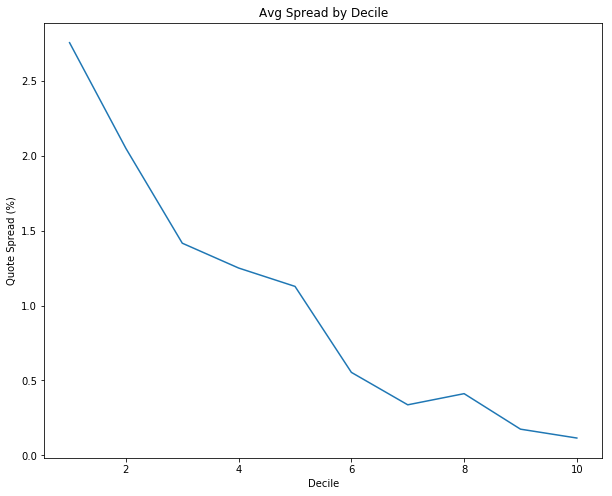

In [32]:
plot_df = summary_df.reset_index()[summary_df.reset_index()['Variable'] == 'Quote Spread (%)'][['Decile', 'mean']].set_index('Decile')
plot_df.plot(title='Avg Spread by Decile', ylabel = 'Quote Spread (%)', legend=False, figsize=(10,8))

In [33]:
bid_ask_df

,PERMNO,DATE,BID,ASK,BIDLO,ASKHI,VOL,PRC,decile_category,ABS_SPREAD,REL_SPREAD,DLR_VOL,DLY_RETURN,DLY_VARIANCE,Quote Spread (%),Bid ($),Ask ($),Volume ($million),Daily Return (%),Return Variance (%)
419,11394.00,2000-02-02,2.78,2.81,2.78,2.88,9939.00,2.81,1.00,0.03,0.01,111550.00,-0.02,0.00,1.12,2.78,2.81,0.11,-2.17,0.20
420,18148.00,2000-02-02,9.44,9.88,7.94,10.94,287315.00,9.88,1.00,0.44,0.05,316744.00,0.23,0.00,4.53,9.44,9.88,0.32,23.44,0.42
421,32062.00,2000-02-02,2.50,2.75,2.50,2.62,6000.00,2.50,1.00,0.25,0.10,0.00,-0.07,0.01,9.52,2.50,2.75,0.00,-6.98,0.89
422,37381.00,2000-02-02,3.50,3.75,3.22,3.75,48330.00,3.75,1.00,0.25,0.07,147315.62,0.02,0.00,6.90,3.50,3.75,0.15,1.69,0.48
423,44230.00,2000-02-02,6.38,6.50,6.28,6.38,4700.00,6.38,1.00,0.12,0.02,25125.00,0.01,0.00,1.94,6.38,6.50,0.03,1.49,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996440,86979.00,2019-12-31,24.63,24.64,24.39,24.71,2291943.00,24.63,10.00,0.01,0.00,53318566.00,0.01,0.00,0.04,24.63,24.64,53.32,0.53,0.01
996441,87299.00,2019-12-31,86.35,86.39,85.35,86.46,662184.00,86.38,10.00,0.04,0.00,52897011.39,0.01,0.00,0.05,86.35,86.39,52.90,0.58,0.01
996442,88031.00,2019-12-31,63.54,63.56,63.17,63.75,1667868.00,63.55,10.00,0.02,0.00,104774441.33,0.00,0.00,0.03,63.54,63.56,104.77,0.30,0.01
996443,88664.00,2019-12-31,145.67,145.72,144.90,145.79,273862.00,145.67,10.00,0.05,0.00,31046725.86,0.00,0.00,0.03,145.67,145.72,31.05,0.19,0.01


## Run Linear Regression

In [34]:
# for i, group in all_data.groupby('decile_category'):
#     X = sm.add_constant(group[['DLR_VOL_detrended', 'VAR_detrended', 'ICS']])
#     Y = group['REL_SPREAD']

#     model = sm.OLS(Y, X).fit()
#     print("\nRegression Results for Decile", i)
#     print(model.summary())

In [35]:
# for i, group in all_data.groupby('decile_category'):
    
#     X = sm.add_constant(group[['DLR_VOL_detrended', 'VAR_detrended', 'CCI']])
#     Y = group['REL_SPREAD']

#     model = sm.OLS(Y, X).fit()
#     print("\nRegression Results for Decile", i)
#     print(model.summary())

In [36]:
# Correlation
all_data.corr()

,decile_category,ABS_SPREAD,REL_SPREAD,DLR_VOL_detrended,VAR_detrended,CCI,ICS,Incidence
decile_category,1.00,-0.38,-0.67,-0.01,-0.04,-0.00,0.00,-0.00
ABS_SPREAD,-0.38,1.00,0.48,-0.04,0.01,0.02,0.02,0.02
REL_SPREAD,-0.67,0.48,1.00,-0.09,0.04,-0.15,-0.15,0.01
DLR_VOL_detrended,-0.01,-0.04,-0.09,1.00,-0.01,0.04,0.05,0.01
VAR_detrended,-0.04,0.01,0.04,-0.01,1.00,-0.03,-0.03,0.01
CCI,-0.00,0.02,-0.15,0.04,-0.03,1.00,0.99,0.00
ICS,0.00,0.02,-0.15,0.05,-0.03,0.99,1.00,0.00
Incidence,-0.00,0.02,0.01,0.01,0.01,0.00,0.00,1.00


## Run SUR (Seemingly Unrelated Regression)

In [37]:
# Change dataset to have each decile have its own set of columns
for i, group in all_data.groupby('decile_category'):
    # Label columns with decile
    group.columns = [str(col) + '_' + str(int(i)) for col in group.columns]
    
    if i == 1:
        data_reorg = group
    else:
        data_reorg = pd.concat([data_reorg, group], axis=1)

In [38]:
data_reorg.head()

,decile_category_1,ABS_SPREAD_1,REL_SPREAD_1,DLR_VOL_detrended_1,VAR_detrended_1,CCI_1,ICS_1,Incidence_1,decile_category_2,ABS_SPREAD_2,...,ICS_9,Incidence_9,decile_category_10,ABS_SPREAD_10,REL_SPREAD_10,DLR_VOL_detrended_10,VAR_detrended_10,CCI_10,ICS_10,Incidence_10
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,1.00,0.19,0.03,0.17,1.41,1.11,94.70,0.91,2.00,0.16,...,94.70,0.91,10.00,0.08,0.00,1.10,1.14,1.11,94.70,0.91
2001-02-01,1.00,0.21,0.05,0.21,1.25,0.68,90.60,0.91,2.00,0.21,...,90.60,0.91,10.00,0.09,0.00,1.27,1.10,0.68,90.60,0.91
2001-02-02,1.00,0.21,0.05,0.13,1.18,0.68,90.60,0.90,2.00,0.15,...,90.60,0.90,10.00,0.11,0.00,1.26,0.98,0.68,90.60,0.90
2001-02-05,1.00,0.21,0.04,0.13,1.15,0.68,90.60,0.89,2.00,0.15,...,90.60,0.89,10.00,0.09,0.00,0.91,0.85,0.68,90.60,0.89
2001-02-06,1.00,0.24,0.05,0.12,1.12,0.68,90.60,0.88,2.00,0.14,...,90.60,0.88,10.00,0.07,0.00,0.95,0.78,0.68,90.60,0.88


In [39]:
# # Create dictionary of regression equations (ICS)
# formula_ICS = {}
# for i in range(1, 11):
#     formula_ICS['eq{}'.format(i)] = 'REL_SPREAD_{} ~ 1 + DLR_VOL_detrended_{} + VAR_detrended_{} + ICS_{} + Incidence_{}'.format(i, i, i, i, i)
    
# # Get the model
# model_ICS = SUR.from_formula(formula_ICS, data_reorg)
# res_ICS = model_ICS.fit(cov_type='unadjusted')
# print(res_ICS)

In [40]:
# Create dictionary of regression equations (CCI)
formula_CCI = {}
for i in range(1, 11):
    formula_CCI['eq{}'.format(i)] = 'REL_SPREAD_{} ~ 1 + DLR_VOL_detrended_{} + VAR_detrended_{} + CCI_{} + Incidence_{}'.format(i, i, i, i, i)
    
# Get the model
model_CCI = SUR.from_formula(formula_CCI, data_reorg)

res_CCI = model_CCI.fit(cov_type='unadjusted')
print(res_CCI)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0905
No. Equations.:                    10   McElroy's R-squared:                 0.0661
No. Observations:                4759   Judge's (OLS) R-squared:             0.0905
Date:                Wed, Apr 14 2021   Berndt's R-squared:                 -0.3008
Time:                        16:43:52   Dhrymes's R-squared:                 0.0905
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                    Equation: eq1, Dependent Variable: REL_SPREAD_1                    
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
Intercept               0.0262     0.0003     75.168     0.0000 

In [41]:
test_df = bid_ask_estimate(bid_ask_df, id_col = 'PERMNO', date_col='DATE', high_col='ASKHI', low_col='BIDLO')

In [60]:
test_df = test_df[['DATE','PERMNO','REL_SPREAD', 'CW_spread_estimate']]
test_df['error'] = test_df.REL_SPREAD - test_df.CW_spread_estimate
test_df = test_df[test_df.CW_spread_estimate >= 0]
test_df.error.describe()

count   782116.00
mean        -0.09
std          0.05
min         -0.20
25%         -0.13
50%         -0.10
75%         -0.06
max          1.24
Name: error, dtype: float64